#### PROJECT : Bolt : Data Science Assessment $\;\;\;\;\;\;\;\;\;\;$  Author: Adegboyega Adesanya $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$Date: April 30, 2022

**Task intro:**

*Value Based Order Location Anticipation*

Availability of supply depends on the duration of time it takes for the drivers to reach the customers. For this test task we expect you to:

**Objectives:**
- Explore the viability of algorithmic order location anticipation based on the data provided to guide the driver towards areas of highest ride value.
- Build a documented simple baseline model.
- Describe how you would deploy such a model.
- Think through and describe the randomized experiment (AB-test) for live operations.

#### Steps/Approach (CRISP-DM Methodology):
- **Business Understanding** - Understand the business pain point from the objectives we are looking to achieve.
- **Data Gathering** - Gather relevant data to solve business problem (the provided data)
- **Data understanding** - A quick run through the data to understand each field and what it means.
- **Data Preparation:**
    - *Exploratory Data Analysis (EDA)*: Here the data is assessed and visualized to better understand it
    - *Data Cleaning/ Preprocessing*: Missing values are handled here, unwanted data are dropped or modified to suit our purpose
    - *Data Preparation for modelling*: Here we balance the dataset if possible, tokenize it, normalize/standardize the data
- **Modelling** - Using different machine learning algorithms, we train several models, tune its parameters and select one which best solve the business problem
- **Evaluation** - This is based on the selected model; we evaluate it with the holdout/ test dataset. 

In [1]:
# import necessary data manipulation libraries
import pandas as pd
import numpy as np

# import data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Import the neccessary machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

## other useful notebook settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
## Read in the dataset
data = pd.read_csv('robotex5.csv')

In [3]:
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [4]:
data.shape

(627210, 6)

### 1. Data Understanding
This section helps us understand better the dataset and what each feature stands for. We also get to see the datatypes and better understand how to perform our analysis moving forward.

**To Do:**
- Read in the data
- Check data info for data types and missing values
- Univariate Statistical analysis

#### Dataset Features
- start_time - time when the order was made
- start_lat - latitude of the location where the order was made
- start_lng - longitude of the location where the order was made
- end_lat - latitude of the destination point
- end_lng - longitude of the destination point
- ride_value - how much monetary value is in this particular ride

In [5]:
# Make a copy of the original dataset
data_copy = data.copy()

In [6]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


In [7]:
## Univariate Statiscal Analysis of dataset 
data_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
start_lat,627210.0,59.428682,0.021764,59.321557,59.418803,59.432069,59.439024,59.566998
start_lng,627210.0,24.743468,0.056872,24.505199,24.713140,24.744674,24.768115,24.973743
end_lat,627210.0,59.397797,1.392755,-37.819979,59.415215,59.430697,59.439262,61.552744
end_lng,627210.0,24.724847,1.650709,-122.453962,24.707919,24.744335,24.773924,144.966110
ride_value,627210.0,2.261384,44.889892,0.107628,0.545250,1.059000,1.712000,3172.701000


**Note:** From data understanding, I got to notice the follwoing:

- Start Time - present
- End time - absent. This would be an additional data point that would be necessary to properly analyze this dataset

With the absence of end time in the dataset, a methodical approach would be taken to properly analyze this data and get the best out of it in order to achieve the set objectives.

### 2. Exploratory Data Analysis (EDA)

The exploratory data analysis section is where we get to understand the data better using visualizations. Most times there is always a reference variable to do this analysis against in order to under data distribution. 

In this task we will try to visualize the dataset based on pick-up locations and destination points as against the ride value.

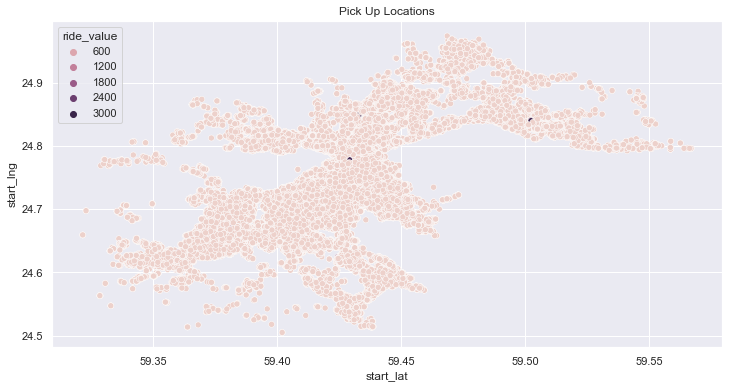

In [8]:
## Pick Up locations
plt.figure(figsize=(12,6))
sns.scatterplot(data_copy['start_lat'],data_copy['start_lng'], hue=data_copy['ride_value'])
plt.title('Pick Up Locations');

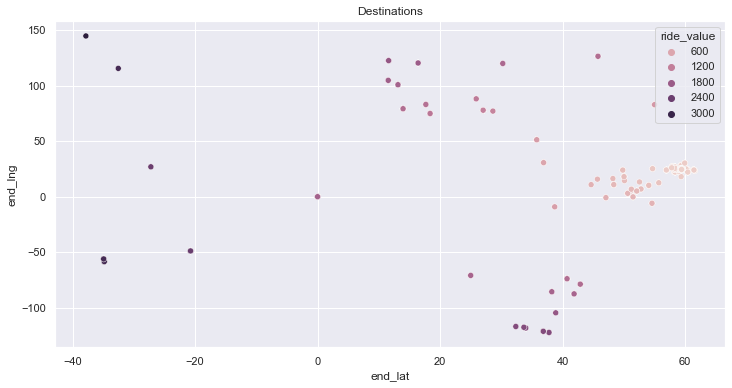

In [9]:
## Destinations
plt.figure(figsize=(12,6))
sns.scatterplot(data_copy['end_lat'],data_copy['end_lng'], hue=data_copy['ride_value'])
plt.title('Destinations');

#### Determining Travel Time

The dataset provided has a start time, location coordinates and ride value. In order to make a good use of this dataset, it is imperative we have an end time (the time of arrival at destination). This value would ensure we have a better understanding of how long the journey took with respect to journey cost( ride value). 

Since this is missing, we create our own travel time from the provided information. We use the coordinates, especially the start and end longitude to get the travel time. From geography, it is known that time can be obtained from longitude values. As such that was used in estimating travel time in minutes.

**Intuition:** The earth makes a 360 degrees rotation on its axis everyday. i.e **360 degrees in 24 hours**. which equates to **4 minutes for every degree turned.** The same intuition is applied to distance traveled and change in location from a certain starting longitude to end longitude. And since ***for every 4 minutes drive, 1 degree distance is covered***, we get our travel time using this logic.

**Note:** If this logic works, then we should see a relationship with travel time and ride value.

In [10]:
### A function to estimate time of travel
def travel_time(data, start_long, end_long):
    '''
    This function returns travel time in minutes bases on provided starting longitude and ending longitude
    
    parameters::
    - data:: DataFrame Object
    - start_long:: Longitude of the starting location
    - end_long:: Longitude of the destination
    
    output::
    Travel time:: Time in Minutes
    Abs_long_diff:: Absolute difference in longitude values
    '''
    ## Absolute longitudinal difference
    long_diff = np.abs(data[start_long] - data[end_long])
    
    ## Longitude difference
    data['Abs_long_diff'] = long_diff
    
    ### 1 degree == 4 minutes i.e. it takes 4 minutes to cover distance represented by 1 degree
    time_in_mins = long_diff * 4
    
    return time_in_mins

In [11]:
## Create a new variable travle time in minutes to dataset copy
data_copy['travel_time (mins)'] = travel_time(data_copy, 'start_lng', 'end_lng')

In [12]:
data_copy.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,Abs_long_diff,travel_time (mins)
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825,0.141794,0.567174
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750,0.020363,0.081452
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025,0.011792,0.047170
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600,0.017354,0.069416
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100,0.122529,0.490117


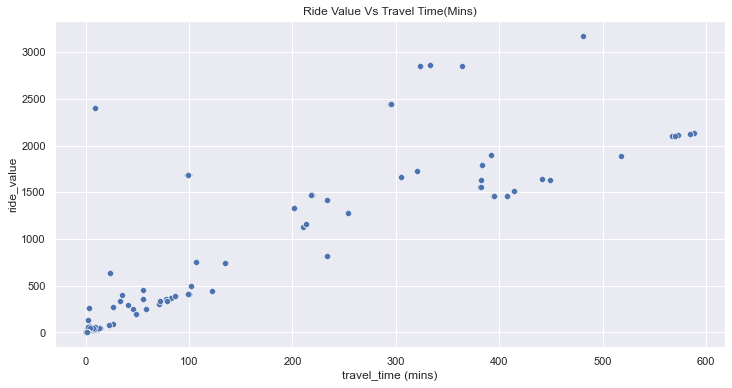

In [13]:
plt.figure(figsize=(12,6))
sns.scatterplot(data_copy['travel_time (mins)'], data_copy['ride_value'])
plt.title('Ride Value Vs Travel Time(Mins)');

**Note:** It can be observed that there is a positive correlation with ride value and travel time. As travel time increases, ride value increases. This shows time of travel has been obtained correctly!

### 3. Data Preparation for Modelling

In this section, data preparation would take a different approach in that we want to understand the relationship between ride value and travel time. It is necessary in order to be able to group population in their respective class. As such, a **Clustering Approach** would be utilized.

**To DO:**
- Dimensionality Reduction (if necessary)
- Determining appropriate numbers of clusters
- Properly label population based on cluster they fall under
- Sample Selection
- Handling Imabalance Dataset

**Intuition:**
The primary goal of this task is to **guide the driver towards areas of highest ride value.** To do this it is vital that a clear pattern is defined based on pick-up locations, destination and travel time.

#### 3.1 Dimensionality Reduction
This is simply the process of dropping irrelavnt variables or selecting best features needed for a particular process.
##### Advantages of Dimensionality Reduction:
- The main goal of dimensionality reduction is to select the best possible variables for modelling. 
- It also helps to prevent overfitting
- It saves computation cost
- proper representation of the entire dataste on a 2-D graph (PCA)

In clustering, dimensionality reduction is usually done using **Principal Component Analysis (PCA)**. PCA is a dimensionality reduction algorithm. It takes in the dataset and returns features or number of components that has been specified. PCA works checking correlation between features, assessing variance and returning features having relevant information about the datasets as components. The first component have the most information, followed by the next depending on the number of component specified. If 2 components are selected during PCA, this helps in a 2-D representation of the whole dataset.

**Recall** we derived Travel time from location coordinates(start and end longitudes). This makes derived travle time represent variables holding the coordinates. The other important variable in the dataste is the ride value. With these 2 variables, we have a fairly good representation of the dataset.

In [14]:
### Select data points that are a true representative of the dataset,  
data_x = data_copy[['ride_value','travel_time (mins)']]

In [15]:
# dataset scaled to prevent bias in features with large values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_x)

#### 3.2 Determing Number of Cluster (Elbow method)

The Elbow method of selecting number of clusters works on the principle of distance between points and sum of squared errors (SSE). While it is okay to pick centroids randomly, SSE is being calculated on each points, depending on the number of centroids. Centroids adjusts their positions as they increase in the dataset till an optimum K value is reached where the sample points would not change clusters. Most times, this K value is just around the curve (elbow) of SSE vs K plot.

In [16]:
# Determining K value for K-means

# We select varying values of K and calculate sum of squared errors (SSE) from them
k_range = range(1,11)
sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    # fit in the scaled data_copy
    km.fit(scaled_data)
    # The inertia attribute of the KMeans class helps in calculating SSE for each value of K
    sse.append(km.inertia_)

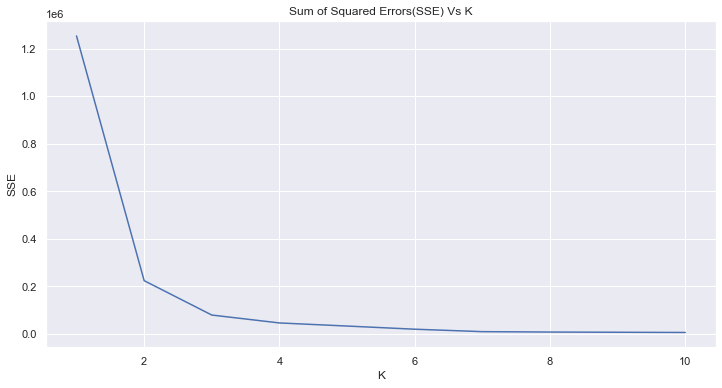

In [17]:
# The Elbow Plot

plt.figure(figsize=(12,6))

plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Sum of Squared Errors(SSE) Vs K')
plt.plot(k_range, sse);

In [18]:
# using 3 clusters
km3 = KMeans(n_clusters=3)
km3.fit(scaled_data)

KMeans(n_clusters=3)

In [19]:
data_ = pd.DataFrame(data=scaled_data, columns=data_x.columns, index=data_x.index)
data_.head() 

,ride_value,travel_time (mins)
0,0.027999,0.024581
1,-0.039071,-0.049068
2,-0.046138,-0.054266
3,-0.033535,-0.050893
4,0.000214,0.012897


In [20]:
# Depending on the number of clusters, KMeans tend to predict and label samples based on their clusters
# KMeans.labels_ reveals these labels
data_['clusters'] = km3.labels_

In [21]:
# Kmeans.cluster_centers_ gives position of the centroid in their respective clusters
km3.cluster_centers_

array([[-2.13256069e-02, -1.90669633e-02],
       [ 3.45124981e+01,  1.84967681e+01],
       [ 5.11704799e+01,  5.89245171e+01]])

In [22]:
data_.head()

,ride_value,travel_time (mins),clusters
0,0.027999,0.024581,0
1,-0.039071,-0.049068,0
2,-0.046138,-0.054266,0
3,-0.033535,-0.050893,0
4,0.000214,0.012897,0


#### Plot Clusters

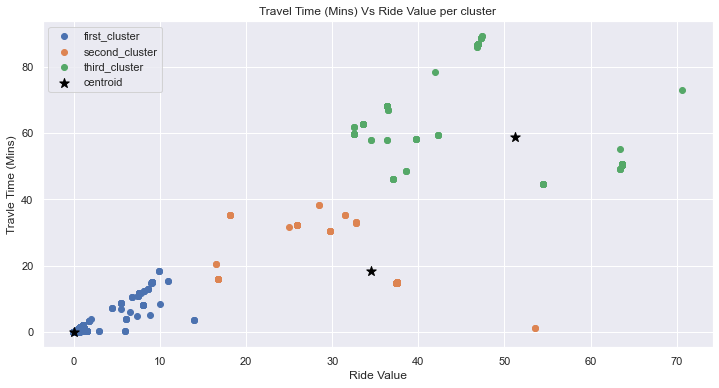

In [23]:
data_1 = data_[data_.clusters==0]
data_2 = data_[data_.clusters==1]
data_3 = data_[data_.clusters==2]

plt.figure(figsize=(12,6))

plt.scatter(data_1['ride_value'], data_1['travel_time (mins)'], label='first_cluster')
plt.scatter(data_2['ride_value'], data_2['travel_time (mins)'], label='second_cluster')
plt.scatter(data_3['ride_value'], data_3['travel_time (mins)'], label='third_cluster')

plt.scatter(km3.cluster_centers_[:,0],km3.cluster_centers_[:,1], color='black', marker='*',s=100,label='centroid')

plt.xlabel('Ride Value')
plt.ylabel('Travle Time (Mins)')
plt.title('Travel Time (Mins) Vs Ride Value per cluster')

plt.legend();

In [24]:
## Population Count per Cluster
data_['clusters'].value_counts()

0    626896
1       162
2       152
Name: clusters, dtype: int64

#### 3.3 Labeling Population based on Cluster

Label the original dataset based on clusters

In [25]:
### Label original data set with cluster values
data['clusters'] = data_['clusters']
data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value,clusters
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825,0
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750,0
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025,0
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600,0
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100,0


In [26]:
data['clusters'].value_counts()

0    626896
1       162
2       152
Name: clusters, dtype: int64

#### 3.4 Sample Selection

Sampling is done with the sole purpose of getting a part of the population that would represent the population at large. In this case, we sample because a certain section (0) of the population is overwhelmingly large compared to the others(1 & 2). In order not to discard population 1 & 2 or treat them as outliers, we sample a part of population 0 and maintained population in 1 & 2.

In [27]:
### Select samples based on clusters
zeros_population = data[data['clusters']==0] ### closest distance and cheapest ride value
ones_population = data[data['clusters']==1]  ### farthest distance and expensive ride value
twos_population = data[data['clusters']==2]  ### moderate distance and relatively expensive ride value

In [28]:
from sklearn.utils import shuffle

In [29]:
# Randomly subselect 1000 samples from the '0' population. Random_State ensures we select the same sample population always
zeros_population = zeros_population.sample(n=1000, random_state=33)

In [30]:
### Merge all samples from the population 0, 1 and 2
selected_population = pd.concat([zeros_population, ones_population, twos_population], axis=0)

In [31]:
selected_population['clusters'].value_counts()

0    1000
1     162
2     152
Name: clusters, dtype: int64

**Note:** After careful sampling, we now have 1000 from population 0, 152 from 1 and 162 from 2. We wil use this population to train a model that would represent the larger population.

0    1000
1     162
2     152
Name: clusters, dtype: int64


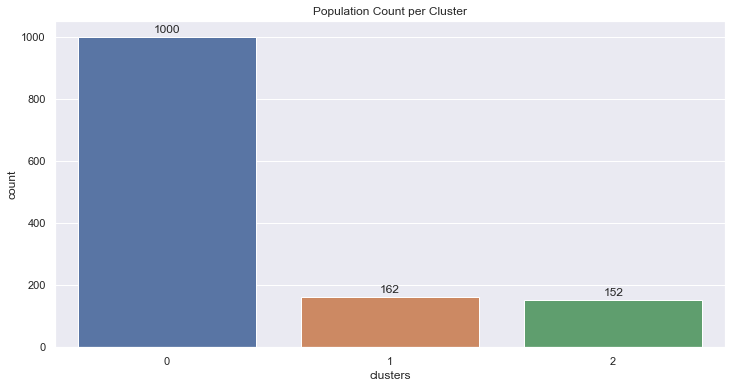

In [32]:
### Visual Representation of Population count per cluster
print(selected_population['clusters'].value_counts())

plt.figure(figsize=(12,6))
plots = sns.countplot(selected_population['clusters'])
plots.set_title('Population Count per Cluster')

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),  
                       (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                       size=12, xytext=(0, 7), 
                       textcoords='offset points')

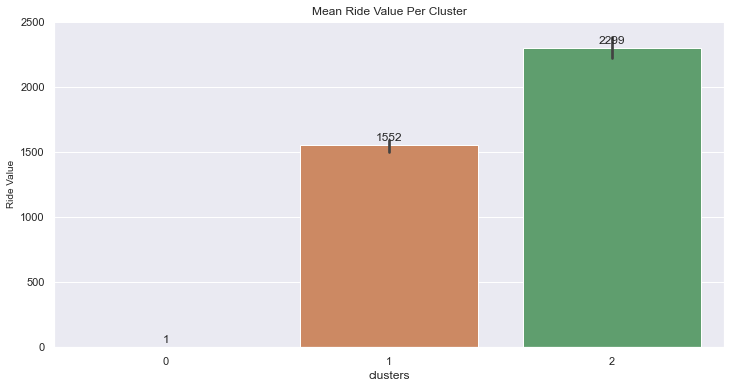

In [33]:
# Avergae Ride Value Per cluster
plt.figure(figsize=(12,6))
plots = sns.barplot(x=selected_population['clusters'], y=selected_population['ride_value'])
plots.set_title('Mean Ride Value Per Cluster')
plots.set_ylabel('Ride Value', fontsize=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),  
                       (bar.get_x() + bar.get_width() / 2,  
                        bar.get_height()), ha='center', va='center', 
                       size=12, xytext=(0, 7), 
                       textcoords='offset points')

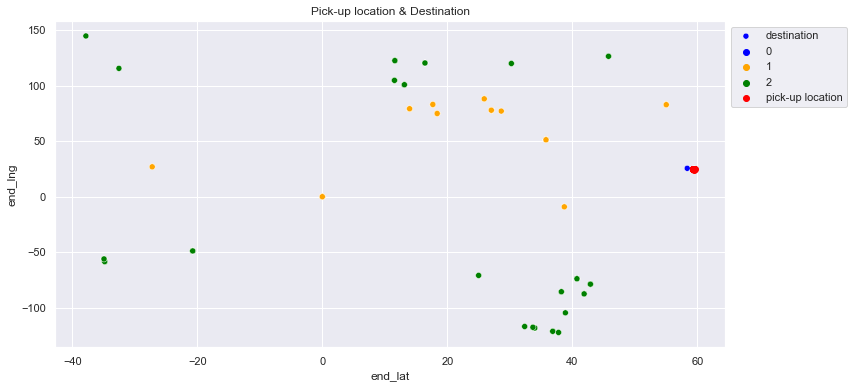

In [34]:
### Pick up location and Destination based on Clusters and Ride Value
plt.figure(figsize=(12,6))

palette = {0:"blue",
           1:"orange", 
           2:"green"}

sns.scatterplot(x='end_lat', y='end_lng', data=selected_population, hue='clusters', label='destination', palette=palette)
plt.scatter(x='start_lat', y='start_lng', data=selected_population, color='red', label='pick-up location')

plt.title('Pick-up location & Destination')
plt.legend(loc=2, bbox_to_anchor = (1,1));

**Note:** 
- Cluster 0 with color blue represents shortest distance and cheapest ride values
- Cluster 1 with color yellow represents moderately far distance with fairly expensive ride values
- cluster 2 with color green represents farthest distance and expensive ride values

#### Data Splitting

In [35]:
### Shuffle the dataset to have a mix of the population
selected_population = shuffle(selected_population, random_state=42)

In [36]:
### Split Dataset

# Select independent variables relevant for modelling
X = selected_population.drop(['start_time', 'ride_value', 'clusters'], axis=1)

# Select target variable
y = selected_population['clusters']

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=33)

In [39]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (1051, 4)
X_test: (263, 4)
y_train: (1051,)
y_test: (263,)


In [40]:
y_train.value_counts()

0    796
1    129
2    126
Name: clusters, dtype: int64

In [41]:
y_test.value_counts()

0    204
1     33
2     26
Name: clusters, dtype: int64

#### 3.5 Handling Imbalance Dataset

A balanced dataset is vital when building predictive models. Imbalanced dataset will result in a model predicting the majority class most of the time. The result of this being that it understands the trend of the majority class better than the minority class(es).

There are different methods of balancing datasets in other to get the best of our trained model. The most common methods are:

- Undersampling
- Oversampling
- Synthetic minority over-sampling technique (SMOTE)

Undersampling simply reduces the observation in the majority class(es) balancing it with class with the least observation. Undersampling is not very efficient as information will be lost when obsevations are being dropped from the majority class(es). Oversampling does the opposite but with a little difference when considering SMOTE.

For this task, we will be using SMOTE as it has proven to be the best method of generating samples to balance up the minority class(es). SMOTE simply synthesizes elements of the minority class using the existing ones. It randomly chooses a point from the minority class and computes the k-nearest neighbors (default = 5) for this point. The synthetic points are added between the chosen point and its neighbors by choosing a factor between 0 and 1 to multiply the distance.

**NOTE:** Data balancing is done only on the training data

In [42]:
# import the SMOTE library from imblearn for the purpose of balancing the dataset
from imblearn.over_sampling import SMOTE

In [43]:
# Using SMOTE from imbalance learn (imblearn)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [44]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (2388, 4)
y_train: (2388,)


In [45]:
# Balanced population
y_train.value_counts()

0    796
2    796
1    796
Name: clusters, dtype: int64

**Note:** Clusters 0, 1 & 2 Balanced after applying SMOTE technique with each cluster now having 796 samples.

### 4. Modelling & Evaluation

Now that we have prepared and balanced training dataset. It is time to train our model. While bunch of machine learning tasks is done during data preprocessing and preparation, modelling also require special skills in order to build a robust model.

In this modellind section, I will be doing the following:

- Machine learning algorithm selection using Cross Validation Technique
- Hyperparametere Tune the selected algorithm if necessary
- Fit the data on the best algorithm
- Evaluate the newly built model

#### 4.1 Cross Validation for algorithm selection
Cross-validation is a technique majorly used for preventing overfitting. However, it has been used over time in algorithm selection. Cross-validation works by splitting the entire dataset into K number of folds as specified.

For every iteration given a K value, the dataset is splitted into training dataset and validation dataset based on the K value at that iteration. The advantage of using cross-validation during training and algortihm selection is that it uses the entire dataset in the process, there by validating on a specified split and train on the rest of the dataset.

Running cross-validation of different algorithm returns a mean accuracy score which shows which algorithm fits well with the data.

A further step can be to do hyper-parameter tuning on the algorithms with the best mean accuracy to better optimize them for modelling.

In [46]:
# This function performs cross-validation on algorithms and return its mean accuracy
def select_algo(algo, X, y):
    '''
    This function runs cross validation on data and returns mean accuracy
    
    prarmeters ::
    - algo :: Machine Learning Algorithm
    - X :: Independent variables
    - y :: Target Variable
    '''
    cv_scores=cross_val_score(algo, X, y, cv=10, scoring='accuracy')
    
    return cv_scores.mean()

In [47]:
## The 5 selected algorithms(classifiers) to test
classifiers = []

classifiers.append(('Logistic Regression', LogisticRegression()))
classifiers.append(('KNN', KNeighborsClassifier()))
classifiers.append(('Random Forest', RandomForestClassifier()))
classifiers.append(('Naive Bayes', GaussianNB()))
classifiers.append(('Support Vector', SVC()))
classifiers.append(('Multi Layer Paceptron', MLPClassifier()))

In [48]:
#### This process would iteratively pick the above stated algorithms, create a machine learning pipeline and fit the data
best_algo = {}

for classifier in classifiers:
    
    ### Pipeline creation
    pipeline = Pipeline([('Standard Scaler', StandardScaler())])
    pipeline.steps.append(classifier)
    
    ## The select_algo function is instantiated here, this would return a mean score from the cross-validation process
    cv_score = select_algo(pipeline, X_train, y_train)
    
    best_algo.setdefault('Classifier',[]).append(classifier[0])
    best_algo.setdefault('cv_score',[]).append(cv_score)

In [49]:
### The Result of the Cross Validatio process highlighting how the algorithms fit the data
pd.DataFrame(best_algo).sort_values('cv_score', ascending=False, ignore_index=True)

,Classifier,cv_score
0,Random Forest,1.000000
1,Support Vector,1.000000
2,Multi Layer Paceptron,1.000000
3,KNN,0.997069
4,Naive Bayes,0.959374
5,Logistic Regression,0.881919


Since we have 3 algorithms that perfectly fit our dataset we select one. I opt for **Random Forest Classifier**

#### 4.2 Hyper Parameter Tuning

The Major purpose of tuning parameters of an algorithm is to optimally get the best performance of the algorithm. We select few parameters to tune leaving the rest as default and then run iterations which is the number of times the training will occur randomly picking the parameters against themselves.

Tuning parameter can be done using **GridSearch** or **RandomizedSearch.**

**RandomizedSearch is used here due to the fact that GridSearch can be computationally expensive.**

While they give approximately the same result. GridSearch does more but takes time to fit the data.

In [50]:
### Instantiate the classifier
rfc = RandomForestClassifier()

# Scale training data to be used to prevent bias
scaler = StandardScaler()
X_train_tune = scaler.fit_transform(X_train)

# Randomly select parameters to tune
param_dist = dict(
    n_estimators = [100,200,300,400,500], 
    criterion=["gini", "entropy"],
    random_state=[5,10,15,20,25],
    class_weight = ["balanced", "balanced_subsample"],
)

## Range of cross-validation during tuninig
k_range = range(2, 12)

# An empty dictionary to tack tuning results 
k_score = {}

for k in k_range:
    rfc_random = RandomizedSearchCV(rfc, param_dist, cv=k, scoring='accuracy',n_iter=10, n_jobs=-1,verbose=1)
    rfc_random.fit(X_train_tune, y_train)

    k_score.setdefault('Best Accuracy',[]).append(rfc_random.best_score_)
    k_score.setdefault('Best tuned parameter',[]).append(rfc_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 6 folds for each of 10 candidates, totalling 60 fits
Fitting 7 folds for each of 10 candidates, totalling 70 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 9 folds for each of 10 candidates, totalling 90 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 11 folds for each of 10 candidates, totalling 110 fits


In [51]:
### Result of Hyperparameter Tuning by Number of CV
hyp_result = pd.DataFrame(k_score)
hyp_result

,Best Accuracy,Best tuned parameter
0,1.0,"{'random_state': 15, 'n_estimators': 300, 'cri..."
1,1.0,"{'random_state': 5, 'n_estimators': 100, 'crit..."
2,1.0,"{'random_state': 15, 'n_estimators': 500, 'cri..."
3,1.0,"{'random_state': 20, 'n_estimators': 100, 'cri..."
4,1.0,"{'random_state': 10, 'n_estimators': 100, 'cri..."
5,1.0,"{'random_state': 10, 'n_estimators': 300, 'cri..."
6,1.0,"{'random_state': 20, 'n_estimators': 300, 'cri..."
7,1.0,"{'random_state': 20, 'n_estimators': 400, 'cri..."
8,1.0,"{'random_state': 25, 'n_estimators': 300, 'cri..."
9,1.0,"{'random_state': 20, 'n_estimators': 400, 'cri..."


In [52]:
## Get the best parameters returned for Result with the Highes Accuracy
best_parameters = hyp_result[hyp_result['Best Accuracy']==hyp_result['Best Accuracy'].max()]['Best tuned parameter'].values[0]
best_parameters

{'random_state': 15,
 'n_estimators': 300,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

#### 4.3 Fit Random Forest Classifier with the best parameters

**Scaling and Normalization**

Scaling and Normalization is an essential part of every ML process. The reason for this is to prevent bias in our model training process. Scikit learn algorithms tend to attach more importance to features with large numerical figures making the model bias towards features with large numerics. To prevent this and ensure our algorithm train without bias, we scale the dataset. There are differnt methods of scaling our dataset, StandardScaler, MinMax scaler etc.

For this task, StandardScaler is used and as a result, we infuse it in the ML pipeline

In [53]:
## Instantiate the ML pipeline and fit using the best possible parameters
rfc_classifier = Pipeline([
    ('Standard Scaler', StandardScaler()),
    ('Random Forest', RandomForestClassifier(**best_parameters))
])

In [54]:
### Train the model
rfc_classifier.fit(X_train, y_train)

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('Random Forest',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', n_estimators=300,
                                        random_state=15))])

In [55]:
# Make prediction on validation data
predictions = rfc_classifier.predict(X_test)

#### 4.4 Model Evaluation

Model Evaluation is done to understand if our model generalizes on unseen data. A robust model would understand pattern in the dataset and try to predict unseen data/ real-life data based on what it has learned from historical dataset.

There are several metrics for checking how well a model is performing. Here I will be using classification report. The classification report shows some of the best metrics to evaluating machine learning classification tasks (Binary Classifications or Multi-class classifications). It gives extended report in terms of the model precision, recall, fi-score and a general accuracy report.

In [56]:
## Classification Report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        26

    accuracy                           1.00       263
   macro avg       1.00      1.00      1.00       263
weighted avg       1.00      1.00      1.00       263



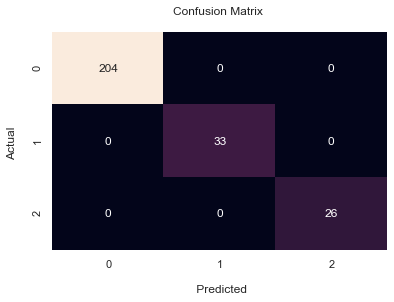

In [57]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=False)

# # labels, title and ticks
ax.set_xlabel('\n Predicted')
ax.set_ylabel('Actual \n')
ax.set_title('Confusion Matrix \n')
ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2]);

#### Model Evaluation Report

From our classification report it is observed the trained model has a general accuracy of **99.99% on the test data**, and it performs well when predicting the mionority samples (1 & 2) as evident in the f1-score. While it is not imperative for all the target class to be equal in proportion, it expected they are fairly close to have a robust data. Hence the reason for balancing the dataset before modelling.

F1-score is the preffered metric used here as it combines **precision** and **recall** in its computation and as such provides the best estimate when predicting class or category of any classification problem rather than just using accuracy.

In the confusion matrix, out of 204  from 0 cluster, the model was able to predict all correctly same goes for other clusters as well. While it might seem the model is overfitting, we should remember we selected the best algorithm that fit the dataset best. A 99.99 % accuracy on train dataset and same for test dataset shows how effective the Random Forest Classifier is. Hence no overfitting is experienced.

Had we selected Logistic Regression Classifier which had 88% on train dataset, we would not be seeing this much performance on test dataset as we see using Random Forest.

#### Conclusion

A model has been created that can efficiently predict **Value Based Order Location Anticipation**. At the provision of pick up coordinates and destination coordinates, drivers can easily anticipate the value of the ride based on what category(cluster) is returned to them.

### Model Deployment Technique

**Deployment Steps:**
- Serialize the model.
- Create an API using Flask, FastAPI or Django
- Create an application (web or Mobile) that users can interact with.
- Create a Dockerfile for the solution.
- Use AWS Elastic Beanstalk to host the application.
- Provide an endpoint that can be connected to.

**Deployment Technologies:**
- **Python**: To create the API

- **AWS**:
    - **Service to use** - **AWS Elastic Beanstalk (EB):** This is one of the numerous AWS services for model/application deployment. EB is easy and fast to use. It also helps in scalability by spinning up instances (EC2 web servers) as traffic increases. It is very cost effective as it scales up and down depending on traffic.
    
- **Docker**: An image of our application will be created which then aid deployment on the AWS server (Elstic Beanstalk). Docker helps in managing deployment by ensuring an application can be used in any environment.

- **Git and GitHub**: Version control tools for mananging development of the application.

### AB-Test

The essence of AB Testing is to ascertain whether a new feature would be embraced by users in terms of interactions. Usually the population is splitted into a predetermined proportion. This split would ensure some users are exposed to a control version while the others are exposed to an adjusted version.

To do this live we expose some drivers to the old ways of engaging riders where they have no clue of the ride value and expose some to the new feature that let them know the value of ride they are about to accept. 

The purpose of AB Test is to see how drivers would react to this new feature. It is advisable to also carry out hypothesis test to understand the impact of AB test on the drivers. A **null hypothesis** could be **"Knowing the value of ride before hand would affect the time it takes for the drivers to reach the customers"** while the alternative hypothesis would negate that. 

AWS Sagemaker has a feature that allows for A/B testing in live environment. This can be leveraged to see the impact of this new features on drivers.